Refer to Pytorch Image Segmentation Tutorial For Beginners, by Seyma Tas, on Medium.

Reproduce the experiment; add and slightly modify the code.

In [ ]:
image_data = []
mask_data = []

In [ ]:
filenames = range(1,3065)

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!cp '/gdrive/My Drive/brainTumorData.zip' 'brainTumorData.zip'
!yes None | unzip -q brainTumorData.zip

In [ ]:
import h5py
import numpy as np

for name in filenames:
  file = h5py.File('/content/brainTumorData/'+str(name)+'.mat', 'r').get('cjdata')
  
  input = file.get('image')[()]
  mask = file.get('tumorMask')[()]
  try: # Use "try" to ignore the unsuitable images.
    input = np.reshape(input,(64,64,64))
    input = np.expand_dims(input,axis=0)
    image_data.append(input)
  except:
    pass

  try:
    mask = np.reshape(mask,(64,64,64))
    mask = np.expand_dims(mask,axis=0)
    mask_data.append(mask)
  except:
    pass

In [ ]:
print(len(image_data))

3049


In [ ]:
from sklearn.model_selection import train_test_split

image_train_data, image_test_data, mask_train_data, mask_test_data = train_test_split(image_data, mask_data, test_size = 0.1, random_state=123)
image_train_data, image_val_data, mask_train_data, mask_val_data = train_test_split(image_train_data,mask_train_data, test_size = 0.111, random_state=123)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
image_train_data = torch.Tensor(image_train_data) 
mask_train_data = torch.Tensor(mask_train_data)

image_val_data = torch.Tensor(image_val_data) 
mask_val_data = torch.Tensor(mask_val_data)

image_test_data = torch.Tensor(image_test_data) 
mask_test_data = torch.Tensor(mask_test_data)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(image_train_data, mask_train_data) # Change it!

val_dataset = torch.utils.data.TensorDataset(image_val_data, mask_val_data)

test_dataset = torch.utils.data.TensorDataset(image_test_data, mask_test_data)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 2, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, num_workers = 2, shuffle = True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, num_workers = 2, shuffle = True)

Use U-Net.

Use unet3d.py from Models Genesis, by Zongwei Zhou, on GitHub.

In [ ]:
class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 5:
            raise ValueError('expected 5D input (got {}D input)'.format(input.dim()))

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv3d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm3d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool3d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose3d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out

class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv3d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet3D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, act='relu'):
        super(UNet3D, self).__init__()

        self.down_tr64 = DownTransition(1,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out

In [ ]:
model = UNet3D()

In [ ]:
weight_dir = '/gdrive/My Drive/Genesis_Chest_CT.pt'

In [ ]:
checkpoint = torch.load(weight_dir,map_location=torch.device('cpu'))

state_dict = checkpoint['state_dict']

In [ ]:
unParalled_state_dict = {}

In [ ]:
for key in state_dict.keys():
  unParalled_state_dict[key.replace("module.", "")] = state_dict[key]

In [ ]:
model.load_state_dict(unParalled_state_dict)

<All keys matched successfully>

Define the loss functions.

Refer to How To Evaluate Image Segmentation Models?, by Seyma Tas, on Towards Data Science.

In [ ]:
def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)
    return bceloss + dicescore

In [ ]:
criterion = bce_dice_loss

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), 0.1)

In [ ]:
from torch.optim import lr_scheduler 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Install CUDA.

In [ ]:
!sudo apt-get -y install aptitude
!sudo aptitude -y install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

Check available GPUs.

Refer to Answer to How to check if pytorch is using the GPU?, by vinzee, on Stack Overflow.

In [ ]:
import torch.cuda

In [ ]:
device = torch.device('cuda:0') # if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
model.to(device)

UNet3D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (

In [ ]:
loss_history = []
loss_history_val = []

In [ ]:
best_loss_val = float('inf')

Training

In [ ]:
print("Start training.")
for epoch in range(10): # Originally 50

    model.train()
    loss_running = []
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
    loss_history.append(np.mean(loss_running))

    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)

    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        torch.save(model.state_dict(), '/gdrive/My Drive/best_model.pth')

    scheduler.step()

    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])

Start training.
epoch 0 train loss 0.7446626443843373 val loss 0.7524707038681229
epoch 1 train loss 0.7264498504458881 val loss 0.7395690524732912
epoch 2 train loss 0.7211288971490547 val loss 0.7225428138460431
epoch 3 train loss 0.7174075757382345 val loss 0.7219881601147837
epoch 4 train loss 0.7118232912704593 val loss 0.7126493678464518
epoch 5 train loss 0.6741519422804723 val loss 0.6830378186393093
epoch 6 train loss 0.6725338343225542 val loss 0.6873202699345428
epoch 7 train loss 0.6666937446496526 val loss 0.697203875362099
epoch 8 train loss 0.6590141191345746 val loss 0.7042116453121234
epoch 9 train loss 0.6624449988857645 val loss 0.6854781162042123


Visualization

In [ ]:
def plot_mask(mask_3d_array, axx):
  mask_cpu = mask_3d_array.cpu().detach().numpy()
  reshaped_mask_cpu = np.reshape(mask_cpu,(512, 512))
  print(np.max(reshaped_mask_cpu), np.min(reshaped_mask_cpu))
  reshaped_mask_cpu_bin = np.round(reshaped_mask_cpu)
  axx.imshow(reshaped_mask_cpu_bin)

0.9785538 2.1595317e-12
1.0 0.0
0.9785538 1.0771206e-11
1.0 0.0
0.9785538 1.4268584e-10
1.0 0.0
0.9785538 1.8579047e-12
1.0 0.0


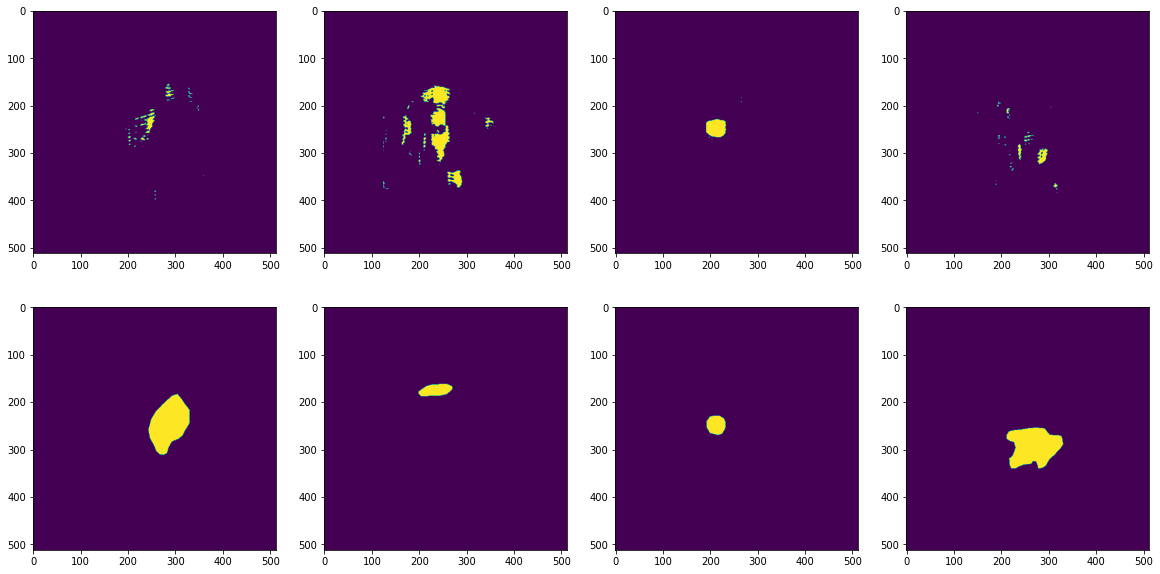

In [ ]:
import random
import matplotlib.pyplot as plt

dataloader = test_dataloader
ncol = 4
rand_ndx = random.sample(range(0, len(dataloader)), ncol)
fig, ax = plt.subplots(nrows=2,  ncols=ncol, figsize=(20, 10))
i = 0
for n, (x, y) in enumerate(dataloader):
  x, y = x.to(device), y.to(device)
  if n in rand_ndx:
    pred = model.forward(x)
    plot_mask(pred[0,0,:,:,:], ax[0][i])
    plot_mask(y[0,0,:,:,:], ax[1][i])
    i += 1